# UMD Security Analysis - Group 17
Members: Zixuan Cao, Jia Guo

## 1. Objective 
Campus security has long been an important issue that should be considered and aware of. After the tragic school gunshot in Florida, we believe it’s necessary to analyze the security situation on and around University of Maryland – College Park to alert faculties and students, and make recommendations to students and UMPD for a more secure campus. 

## 2. Data Description

To achieve the goal mentioned above, we find crime reports from UMPD official website. The data we used is “Daily Crime and Incident Logs” and “Arrest Report Ledgers”. Considering timeliness and reference value of data, we plan to analyze the crime reports in the past five years, i.e. from March 2013 to February 2018. 

“Daily Crime and Incident logs” provides details of each case in every month, every year. Attributes include: 
- Case number (13 digits number)
- Occurred date and time (mm/dd/yy hh:MM)
- Occurred location
- Report date and time (Same format with “Occurred date and time”)
- Type of crime
- Disposition status (CBE, Arrest, Active/Pending).
Reference: http://www.umpd.umd.edu/stats/incident_logs.cfm

“Arrest Report Ledgers” reports details of closed case in every year. Attributes include: 
- Arrest number (5 digits)
- Arrested date and time (mm/dd/yy hh:MM)
- Crime charge (description of the crime)
- Case number (13 digits)
- Age of criminals
- Race of criminals
- Sex of criminals
Reference: http://www.umpd.umd.edu/stats/arrest_report.cfm

## 3. Data Processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### (1) Scraped Daily Crime Report from March 2013 to Feburary 2018 from UMPD official website
The data is stored on a month basis, which makes the last part of the url of each table different. We did a for loop to iterate through all tables and appended them to an entire table named df_year. 

In [2]:
years = [2013, 2014, 2015, 2016, 2017, 2018]
months = range(1, 13)
df_year = pd.DataFrame()
for year in years:
    for month in months:
        if year == 2013 and month < 3 or year == 2018 and month > 2:
            pass
        else:
            url = 'http://www.umpd.umd.edu/stats/incident_logs.cfm?year='+str(year)+'&month='+str(month)
            df = pd.read_html(url, header = None)[0]
            df.columns = df.iloc[0]
            df = df.iloc[1:,:]
            df_year = df_year.append(df)

In [3]:
df_year.head()

,UMPD CASENUMBER,OCCURRED DATE TIMELOCATION,REPORT DATE TIME,TYPE,DISPOSITION
1,2013-00011945,03/01/13 01:49,03/01/13 01:49,Assault,Arrest
2,"Frat 13, Zeta Psi Fraternity at 13 Fraternity Row",NaN,NaN,NaN,NaN
3,2013-00011946,03/01/13 01:38,03/01/13 01:49,Vandalism,Active/Pending
4,"Alpha Sigma Phi, Frat 9 at 9 Fraternity Row",NaN,NaN,NaN,NaN
5,2013-00011949,03/01/13 02:50,03/01/13 02:50,Injured/Sick Person,CBE


### (2) Extract location information and format the table
In the raw table, location information was in the same cell with "Occurred date and time", which is misinterpreted by pandas.read_html to a separate row. We extracted location information from all even lines (2nd row, 4th row ...) and create a new column "LOCATION" for it.  

In [4]:
even_row = df_year.iloc[1::2]
location = even_row['UMPD CASENUMBER']
location[:5]

2     Frat 13, Zeta Psi Fraternity at 13 Fraternity Row
4           Alpha Sigma Phi, Frat 9 at 9 Fraternity Row
6                          Elkton Hall at 254 Denton Dr
8            Drazek Circle, UMUC at 346 Ehrensberger Dr
10    Stamp Student Union, Student Union, Union at 1...
Name: UMPD CASENUMBER, dtype: object

In [5]:
df_year = df_year.drop(df_year.index[1::2])
df_year['LOCATION'] = location.values
df_year.columns = ['UMPD CASE NUMBER', 'OCCURRED DATE TIME', 'REPORT DATE TIME', 'TYPE', 'DISPOSITION', 'LOCATION']
df_year = df_year.reset_index(drop = True)
df_year.head()

,UMPD CASE NUMBER,OCCURRED DATE TIME,REPORT DATE TIME,TYPE,DISPOSITION,LOCATION
0,2013-00011945,03/01/13 01:49,03/01/13 01:49,Assault,Arrest,"Frat 13, Zeta Psi Fraternity at 13 Fraternity Row"
1,2013-00011946,03/01/13 01:38,03/01/13 01:49,Vandalism,Active/Pending,"Alpha Sigma Phi, Frat 9 at 9 Fraternity Row"
2,2013-00011949,03/01/13 02:50,03/01/13 02:50,Injured/Sick Person,CBE,Elkton Hall at 254 Denton Dr
3,2013-00011971,03/01/13 10:40,03/01/13 10:49,Injured/Sick Person,CBE,"Drazek Circle, UMUC at 346 Ehrensberger Dr"
4,2013-00011974,03/01/13 09:50,03/01/13 11:56,Theft,Suspended,"Stamp Student Union, Student Union, Union at 1..."


### (3) Scraped Arrest Report from 2013 to 2018
Similarly, we looped through annual data year by year and developed an entire table. We noticed that the report also contains arrest report of January and February 2013 and March, April, May 2018 (It’s updated since we started the project at the end of February 2018), which is irrelevant to our analysis. But we can automatically drop those records when we merged Arrest Report table and Daily Crime Report table on the common key - UMPD CASE NUMBER. We will demonstrate it later. 

In [6]:
years = [2013, 2014, 2015, 2016, 2017, 2018]
df_arrest = pd.DataFrame()
for year in years:
    url = 'http://www.umpd.umd.edu/stats/arrest_report.cfm?year='+str(year)
    df = pd.read_html(url, header = None)[0]
    df.columns = df.iloc[0]
    df = df.iloc[1:,:]
    df_arrest = df_arrest.append(df)

In [7]:
df_arrest.head()

,ARRESTNUMBER,ARRESTED DATE TIMECHARGE,UMPD CASE NUMBER,AGE,RACE,SEX
1,18237,01/01/13 01:28,2013-00000014,18,Asian/Pacific Islander,Male
2,"(Driving, Attempting to drive) motor veh. with...",NaN,NaN,NaN,NaN,NaN
3,18235,01/01/13 02:30,2013-00000023,NaN,NaN,NaN
4,CDS: Possession of Marijuana,NaN,NaN,NaN,NaN,NaN
5,18236,01/01/13 02:30,2013-00000023,NaN,Asian/Pacific Islander,Male


### (4) Extract arrest reason and format the data frame
Again, similar problem appeared in Arrest Report table. "Charge", which is the arrested reason, was in the same cell with "Arrested date and time" and also misinterpreted to a separate row. We solved it in the same way as what we did to location in Daily Crime data frame.

In [8]:
reason_row = df_arrest.iloc[1::2, :]
reason = reason_row['ARRESTNUMBER']
reason[:5]

2     (Driving, Attempting to drive) motor veh. with...
4                          CDS: Possession of Marijuana
6                          CDS: Possession of Marijuana
8     (Driving, Attempting to drive) motor veh. with...
10                         CDS: Possession of Marijuana
Name: ARRESTNUMBER, dtype: object

In [9]:
df_arrest = df_arrest.drop(df_arrest.index[1::2])
df_arrest['ARREST REASON'] = reason.values
df_arrest.columns = ['ARREST NUMBER','ARRESTED DATE TIME', 'UMPD CASE NUMBER', 'AGE', 'RACE', 'SEX', 'ARREST REASON']
df_arrest = df_arrest.reset_index(drop = True)
df_arrest.head()

,ARREST NUMBER,ARRESTED DATE TIME,UMPD CASE NUMBER,AGE,RACE,SEX,ARREST REASON
0,18237,01/01/13 01:28,2013-00000014,18,Asian/Pacific Islander,Male,"(Driving, Attempting to drive) motor veh. with..."
1,18235,01/01/13 02:30,2013-00000023,NaN,NaN,NaN,CDS: Possession of Marijuana
2,18236,01/01/13 02:30,2013-00000023,NaN,Asian/Pacific Islander,Male,CDS: Possession of Marijuana
3,18238,01/01/13 03:33,2013-00000027,NaN,White,Male,"(Driving, Attempting to drive) motor veh. with..."
4,18239,01/02/13 19:11,2013-00000303,NaN,White,Male,CDS: Possession of Marijuana


### (5) Merge two data frames together on 'UMPD CASE NUMBER'
To establish a holistic view of the crime on campus, we merged clean "Daily Crime" and "Arrest Report" data frames. By left joining:
- We can drop extra arrest report of January and February 2013 and March 2018, because the daily crime data of these months is not imported. (i.e. The left table does not contain information of those months)
- We can fill all arrest information of unarrested cases with NaN. 

In [10]:
df = df_year.merge(df_arrest, how = 'left', on = 'UMPD CASE NUMBER')
df.head()

,UMPD CASE NUMBER,OCCURRED DATE TIME,REPORT DATE TIME,TYPE,DISPOSITION,LOCATION,ARREST NUMBER,ARRESTED DATE TIME,AGE,RACE,SEX,ARREST REASON
0,2013-00011945,03/01/13 01:49,03/01/13 01:49,Assault,Arrest,"Frat 13, Zeta Psi Fraternity at 13 Fraternity Row",18400,03/01/13 01:51,NaN,White,Male,Assault-2nd Degree-Law Enforcement Officer; Si...
1,2013-00011946,03/01/13 01:38,03/01/13 01:49,Vandalism,Active/Pending,"Alpha Sigma Phi, Frat 9 at 9 Fraternity Row",NaN,NaN,NaN,NaN,NaN,NaN
2,2013-00011949,03/01/13 02:50,03/01/13 02:50,Injured/Sick Person,CBE,Elkton Hall at 254 Denton Dr,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-00011971,03/01/13 10:40,03/01/13 10:49,Injured/Sick Person,CBE,"Drazek Circle, UMUC at 346 Ehrensberger Dr",NaN,NaN,NaN,NaN,NaN,NaN
4,2013-00011974,03/01/13 09:50,03/01/13 11:56,Theft,Suspended,"Stamp Student Union, Student Union, Union at 1...",NaN,NaN,NaN,NaN,NaN,NaN


### (6) Drop columns with little help to our analysis
- In the full table, column “ARREST NUMBER” is not contributing to our analysis.So we dropped the column.
- We also noticed that column “AGE” contains too many missing values (1758 out of 3171, over 50%). It's not appropriate to fill missing values with mean or median because the distribution of existing Age data widely ranged and the distribution can be largely affected by the missing half. Filling them may add bias to our analysis so we decided to drop it though there may be trend between crimes and age. Besides, considering the recommendations derived, it's more valuable to be careful about dangerous time and place instead of people in "dangerous age".

In [11]:
missing = df_arrest['AGE'].isnull().sum()
print(missing, len(df_arrest['AGE']))

1758 3171


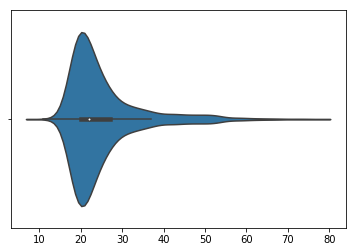

In [12]:
age = df_arrest[df_arrest['AGE'].notnull()]['AGE']
new_age = np.array([int(a) for a in age])
sns.violinplot(new_age)

After visualizing the distribution of age, we decided to drop this column.

In [13]:
df = df.drop(['ARREST NUMBER', 'AGE'], axis = 1)
df.head()

,UMPD CASE NUMBER,OCCURRED DATE TIME,REPORT DATE TIME,TYPE,DISPOSITION,LOCATION,ARRESTED DATE TIME,RACE,SEX,ARREST REASON
0,2013-00011945,03/01/13 01:49,03/01/13 01:49,Assault,Arrest,"Frat 13, Zeta Psi Fraternity at 13 Fraternity Row",03/01/13 01:51,White,Male,Assault-2nd Degree-Law Enforcement Officer; Si...
1,2013-00011946,03/01/13 01:38,03/01/13 01:49,Vandalism,Active/Pending,"Alpha Sigma Phi, Frat 9 at 9 Fraternity Row",NaN,NaN,NaN,NaN
2,2013-00011949,03/01/13 02:50,03/01/13 02:50,Injured/Sick Person,CBE,Elkton Hall at 254 Denton Dr,NaN,NaN,NaN,NaN
3,2013-00011971,03/01/13 10:40,03/01/13 10:49,Injured/Sick Person,CBE,"Drazek Circle, UMUC at 346 Ehrensberger Dr",NaN,NaN,NaN,NaN
4,2013-00011974,03/01/13 09:50,03/01/13 11:56,Theft,Suspended,"Stamp Student Union, Student Union, Union at 1...",NaN,NaN,NaN,NaN


Finally, we got a dataframe with columns: 
- Case number
- Crime occurred date and time
- Crime report date and time
- Crime type
- Case desposition
- Occurred location
- Arrested date and time
- Criminal race
- Criminal gender
- Arrested Reason

## 3. Analysis
Based on common sense, crime should be related to "time", "location" and "demographic information of criminals". Hence, we designed the following exploration:

### (1) Number of crimes with month
First, we want to figure out if there is seasonality in the number of crimes happened. So we separated crime occurred date (mm/dd/yyyy) with occurred time (hh:MM) into two columns and sought the relationship between number of crimes and date. There are cases occurred before March 2013 but reported after that in our dataset, so we chose to drop those records because cases happened after 03/01/2013 were our target. 

In [14]:
# insert new column called 'DATE'
df['DATE'] = pd.to_datetime(df['OCCURRED DATE TIME']).dt.date

In [15]:
# choose occured date after 2013.3.1, which is the start time of our analysis
df_date = df[df['DATE'] > dt.date(2013,3,1)]

In [16]:
# create pivot table and dealing with index format
date = df_date.pivot_table(index = 'DATE',values = 'UMPD CASE NUMBER',aggfunc = 'count')
date.index = pd.to_datetime(date.index)
date.index = date.index.map(lambda x : x.strftime('%Y-%m'))

In [17]:
month=date.groupby(date.index).sum()

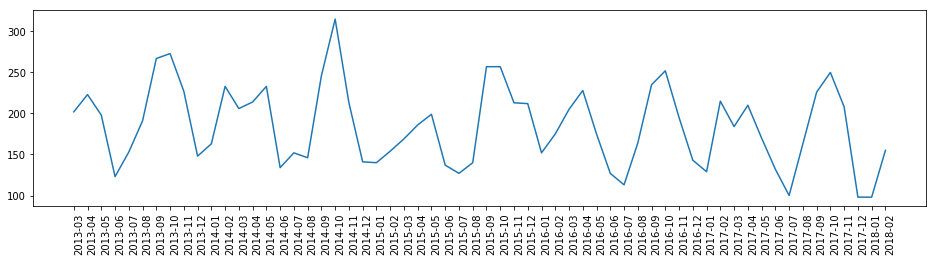

In [18]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(month)
fig.autofmt_xdate(rotation = 90, ha = 'left')

It seems that the fluctuation has no clear trend along date, but the interval between every two raised areas is similar to each other. We then decided to explore the relationship between number of crimes and month. 

In [19]:
date = df_date.pivot_table(index = 'DATE',values = 'UMPD CASE NUMBER',aggfunc = 'count').reset_index()
date['Year'] = date['DATE'].map(lambda x : x.strftime('%Y'))
date['Month']= date['DATE'].map(lambda x : x.strftime('%m'))
date = date.drop('DATE',1)
date = date.astype(int)

In [20]:
# group by year and month
group_by_date = date.groupby(['Month','Year']).sum()
group_by_date = group_by_date.reset_index(level = 1)

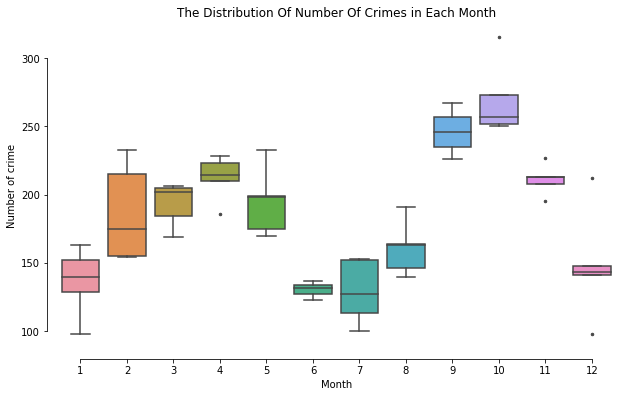

In [21]:
# box plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=group_by_date,y='UMPD CASE NUMBER', x =group_by_date.index, flierprops={'marker': '.'})
sns.despine(left=False, top=True, right=True, trim=True, offset=10) 
ax.set_ylabel('Number of crime')
plt.title('The Distribution Of Number Of Crimes in Each Month');

### Conclusion:
According to the boxplot above, we can tell there is a clear pattern about month and number of incidents. The number of incidences starts to rise in February and reaches first pick in April. Then it drops in June, gradually reaches its second pick in October, and decreases again. The pattern matches University calendar: there are more crimes during the semester, and less crimes during summer vacation and winter vacation. It's probably because less students are in campus during vacations. We can draw conclusion that the number of crimes is related to student behavior, which might indicate that college students are major criminals around UMD.

### (2) Number of crimes with time (24h)
Second, we are interested in "the most dangerous time" in a day. We grouped crimes by hours to see if there is pattern of crimes happening at different time. 

In [22]:
# insert new column 'TIME'
df['TIME'] = pd.to_datetime(df['OCCURRED DATE TIME']).dt.hour

In [23]:
# pivot table about time and number of incedents
time = df.pivot_table(index = 'TIME',values = 'UMPD CASE NUMBER',aggfunc = 'count')

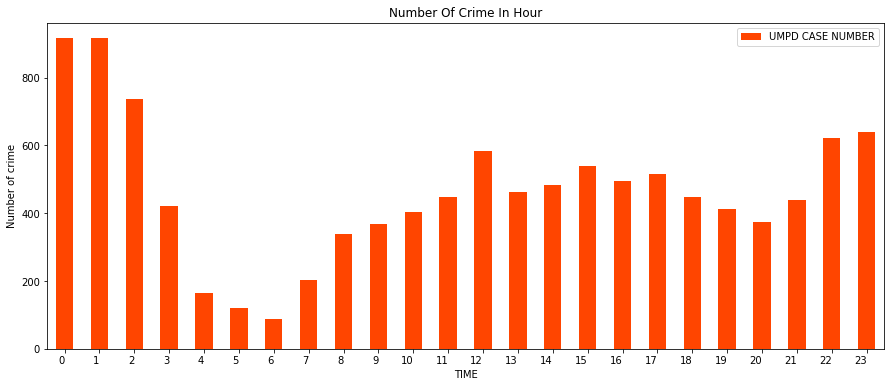

In [24]:
# bar plot
ax = time.plot(kind = 'bar',figsize = (15,6),color = 'orangered')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_ylabel('Number of crime')
plt.title('Number Of Crime In Hour')
plt.show()

### Conclusion:
The bar plot above shows that crimes usually happen during mid-night, and noon. The most dangerous time during the daytime is noon, which might be due to more people heading to different directions during their lunch break and busier street. It's easy for criminals to choose target and escape after committing crimes. Also in the night, 12AM and 1AM are the most dangerous time of, which is quite reasonable. Because night is quieter than daytime, the risk of committing crimes is lower and people are less alert.

### (3) Crime type with gender
After analysis on date and time with crimes happened, it came to us that male and female criminals may perform differently when committing crimes. Hence, we analyzed the relationship between gender and crime type. To better analyze and visualize our results, we grouped low-frequency crimes as "Other". Also, some crime types have annotations in parentheses which make it redundant for visualization, so we re-formatted the type. 

In [25]:
# combine crime type
df['TYPE'] = df['TYPE'].str.replace('\s\([^)]*\)','')
df['TYPE'] = df['TYPE'].str.split(' /').str[0]

In [26]:
# set crime type that appeared less frequent as 'Other'
typ = df.groupby('TYPE').count().sort_values(by = 'UMPD CASE NUMBER',ascending = False)
df['TYPE'] = df['TYPE'].where(df['TYPE'].isin(typ.index[0:20]),'Other')

In [27]:
# create pivot table about gender and crime type
gender = df.pivot_table(index = 'TYPE', columns = 'SEX',values = 'UMPD CASE NUMBER',aggfunc = 'count').sort_values(by = 'Male',ascending = False)

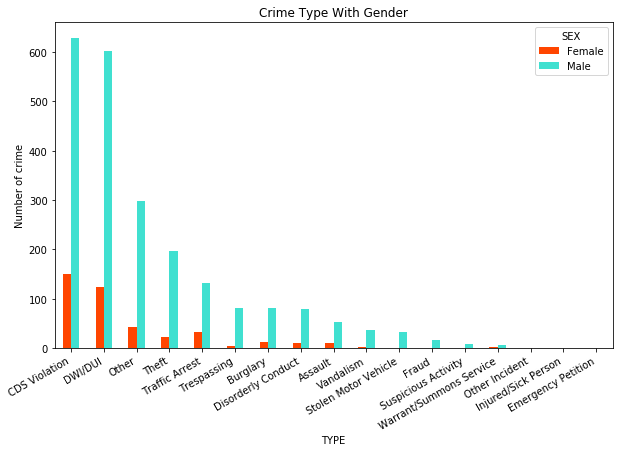

In [28]:
ax = gender.plot(kind = 'bar',figsize = (10,6),color = ['orangered','turquoise'])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_ylabel('Number of crime')
plt.title('Crime Type With Gender')
plt.show()

In [29]:
female = gender['Female'].sort_values(ascending=False)
female

TYPE
CDS Violation              150.0
DWI/DUI                    124.0
Other                       44.0
Traffic Arrest              33.0
Theft                       23.0
Burglary                    12.0
Disorderly Conduct          11.0
Assault                     10.0
Trespassing                  4.0
Warrant/Summons Service      3.0
Vandalism                    2.0
Suspicious Activity          1.0
Fraud                        1.0
Stolen Motor Vehicle         1.0
Other Incident               NaN
Injured/Sick Person          NaN
Emergency Petition           NaN
Name: Female, dtype: float64

In [30]:
male = gender['Male'].sort_values(ascending=False)
male

TYPE
CDS Violation              628.0
DWI/DUI                    601.0
Other                      298.0
Theft                      197.0
Traffic Arrest             132.0
Trespassing                 82.0
Burglary                    81.0
Disorderly Conduct          79.0
Assault                     53.0
Vandalism                   38.0
Stolen Motor Vehicle        33.0
Fraud                       16.0
Suspicious Activity          8.0
Warrant/Summons Service      6.0
Injured/Sick Person          1.0
Other Incident               1.0
Emergency Petition           1.0
Name: Male, dtype: float64

### Conclusions:
Obviously, male committed more crimes than female. And quite surprisingly, the most 'popular' crime is CDS violation (Controlled Drug Substance), and DWI/DUI, (Driving Under/With Influence). Combined with our previous analysis on dangerous time, we can picture some college students are having party around midnight and got caught because some of the actions they did. The list can help to show details more clearly. 

### (4) Crime type with respond time
We noticed that for some cases, it's reported right after it happened; while for other, it may be reported a long time after the occurrence, even after years. Then we planned to dig into the possible reasons in order to get some insights. To do that, we created a column named "RESPONSE" for response time of a case. 

In [31]:
# transform time to datetime object
df['REPORT DATE TIME'] = pd.to_datetime(df['REPORT DATE TIME'])
df['OCCURRED DATE TIME'] = pd.to_datetime(df['OCCURRED DATE TIME'])

In [32]:
# insert column 'RESPONSE'
df['RESPONCE']=  df['REPORT DATE TIME']-df['OCCURRED DATE TIME']
df['RESPONCE'] = pd.to_datetime(df['RESPONCE']).dt.minute

In [33]:
type_time = df.pivot_table(index = 'TYPE', values = 'RESPONCE',aggfunc = 'mean').sort_values(by = 'RESPONCE',ascending = False)

In [34]:
sort_rsp = type_time

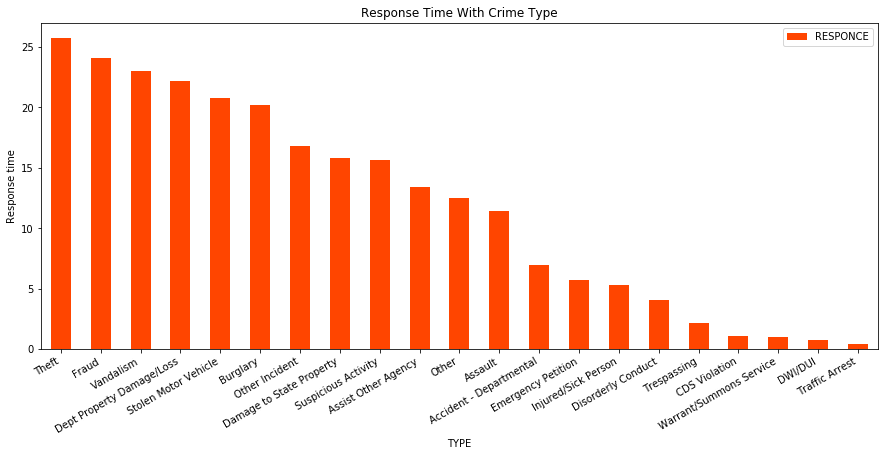

In [35]:
# bar plot
ax = sort_rsp.plot(kind = 'bar',figsize = (15,6),color = 'orangered')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_ylabel('Response time')
plt.title('Response Time With Crime Type')
plt.show()

### Conclusions: 
Response time is the time when people realize something bad happen to them and report to law enforcement. We thought there might be a relationship between crime type and response time. The highest average response time is more than 25 minutes, and the crime type associated with it is Theft. The second one is Fraud and Vandalism (destroy public property). These types of crime are hard to be noticed by victims. It might take more than 20 minutes to notice something happened. As for crime like CDS violation, DWI/DUI, Traffic Arrest, it is hard to tell when does the crime occurred, and is happening when police officers find criminals.

### (5) Number of crimes with location
At last, we believed that there were some dangerous places on campus where crimes occurred more frequently. It would help a lot if we found them out. Hence, we plotted an interactive map to see the relationship between number of crimes and locations.

In [36]:
import requests
from random import randint
from time import sleep

In [37]:
# Drop records with missing location information
loc = df[df['LOCATION'].notnull()]
loc.tail()

,UMPD CASE NUMBER,OCCURRED DATE TIME,REPORT DATE TIME,TYPE,DISPOSITION,LOCATION,ARRESTED DATE TIME,RACE,SEX,ARREST REASON,DATE,TIME,RESPONCE
11133,2018-00013734,2018-02-28 06:19:00,2018-02-28 06:19:00,Injured/Sick Person,CBE,Oakland Hall at 3912 Denton Service Ln,NaN,NaN,NaN,NaN,2018-02-28,6,0
11134,2018-00013823,2018-02-28 13:29:00,2018-02-28 13:29:00,Injured/Sick Person,CBE,Health Center at 3983 Campus Dr,NaN,NaN,NaN,NaN,2018-02-28,13,0
11135,2018-00013824,2018-02-23 16:00:00,2018-02-28 13:30:00,Vandalism,Active/Pending,"Clarice Smith Performing Arts Center, CSPAC at...",NaN,NaN,NaN,NaN,2018-02-23,16,30
11136,2018-00013836,2018-02-28 14:14:00,2018-02-28 14:19:00,Injured/Sick Person,CBE,Lot 11b,NaN,NaN,NaN,NaN,2018-02-28,14,5
11137,2018-00013886,2018-01-26 17:00:00,2018-02-28 20:21:00,Fraud,Summons Issued,3900 block of Campus Dr,NaN,NaN,NaN,NaN,2018-01-26,17,21


In [38]:
crime_loc = df.groupby('LOCATION')['UMPD CASE NUMBER'].count()
crime_loc[:5]

LOCATION
013 at 13 Greenhouse Dr           2
1 Fraternity Row                  2
10 Fraternity Row                 3
1000 block of Kennebec St         1
1000 block of Rhode Island Ave    1
Name: UMPD CASE NUMBER, dtype: int64

We converted street address to latitude and longitude to facilitate our analysis with the help of Google Map API (https://maps.googleapis.com/maps/api/geocode). However, because of the connection block after too many requests from it at one time, it failed to return coordinates of some location. We had to request repeatedly for rejected requests and refill them to the original coordinates list. We kept requesting for location in the "wrong_loc". a list of rejected requests, from the previous iteration until all locations were returned.

In [39]:
# Convert location to correct format to feed to Google Map API and get longitude and latitude
ser = crime_loc.index
ser = ser.str.split()
ser = ser.map(lambda loc: '+'.join(loc)+',+College+Park,+MD')
ser[:5]

Index(['013+at+13+Greenhouse+Dr,+College+Park,+MD',
       '1+Fraternity+Row,+College+Park,+MD',
       '10+Fraternity+Row,+College+Park,+MD',
       '1000+block+of+Kennebec+St,+College+Park,+MD',
       '1000+block+of+Rhode+Island+Ave,+College+Park,+MD'],
      dtype='object', name='LOCATION')

In [41]:
%%time
#First iteration, stored results in lat1 and long1
latitude = []
longitude = []
wrong_loc = []
for loc in ser:    
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+loc)
    resp_json = response.json()
    try:
        lat = resp_json['results'][0]['geometry']['location']['lat']
        lng = resp_json['results'][0]['geometry']['location']['lng']
    except:
        lat = 0
        lng = 0
        wrong_loc.append(loc)
    latitude.append(lat)
    longitude.append(lng)

Wall time: 10min 24s


In [42]:
lat1 = latitude
long1 = longitude
wrong1 = wrong_loc

In [43]:
len(wrong1)

313

In [44]:
%%time
# Second iteration
latitude = []
longitude = []
wrong_loc = []
for loc in wrong1:    
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+loc)
    resp_json = response.json()
    try:
        lat = resp_json['results'][0]['geometry']['location']['lat']
        lng = resp_json['results'][0]['geometry']['location']['lng']
    except:
        lat = 0
        lng = 0
        wrong_loc.append(loc)
    latitude.append(lat)
    longitude.append(lng)
    sleep(randint(2,3))

Wall time: 16min 3s


In [45]:
lat2 = latitude
long2 = longitude
wrong2 = wrong_loc

In [46]:
len(wrong2)

96

In [47]:
%%time
# Third iteration
latitude = []
longitude = []
wrong_loc = []
for loc in wrong2:    
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+loc)
    resp_json = response.json()
    try:
        lat = resp_json['results'][0]['geometry']['location']['lat']
        lng = resp_json['results'][0]['geometry']['location']['lng']
    except:
        lat = 0
        lng = 0
        wrong_loc.append(loc)
    latitude.append(lat)
    longitude.append(lng)
    sleep(randint(2,3))

Wall time: 5min 3s


In [48]:
lat3 = latitude
long3 = longitude
wrong3 = wrong_loc

In [49]:
len(wrong3)

21

In [50]:
%%time
# Forth iteration
latitude = []
longitude = []
wrong_loc = []
for loc in wrong3:    
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+loc)
    resp_json = response.json()
    try:
        lat = resp_json['results'][0]['geometry']['location']['lat']
        lng = resp_json['results'][0]['geometry']['location']['lng']
    except:
        lat = 0
        lng = 0
        wrong_loc.append(loc)
    latitude.append(lat)
    longitude.append(lng)
    sleep(randint(2,3))

Wall time: 1min 1s


In [51]:
lat4 = latitude
long4 = longitude
wrong4 = wrong_loc

In [52]:
len(wrong4)

7

In [54]:
%%time
# Fifth iteration
latitude = []
longitude = []
wrong_loc = []
for loc in wrong4:    
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+loc)
    resp_json = response.json()
    try:
        lat = resp_json['results'][0]['geometry']['location']['lat']
        lng = resp_json['results'][0]['geometry']['location']['lng']
    except:
        lat = 0
        lng = 0
        wrong_loc.append(loc)
    latitude.append(lat)
    longitude.append(lng)
    sleep(randint(2,3))

Wall time: 18.6 s


In [55]:
lat5 = latitude
long5 = longitude
wrong5 = wrong_loc

In [56]:
len(wrong5)

3

In [57]:
response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+wrong_loc[0])
resp_json = response.json()
lati_wrong0 = resp_json['results'][0]['geometry']['location']['lat']
lngi_wrong0 = resp_json['results'][0]['geometry']['location']['lng']

In [58]:
response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+wrong_loc[1])
resp_json = response.json()
lati_wrong1 = resp_json['results'][0]['geometry']['location']['lat']
lngi_wrong1 = resp_json['results'][0]['geometry']['location']['lng']

In [59]:
response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+wrong_loc[2])
resp_json = response.json()
lati_wrong2 = resp_json['results'][0]['geometry']['location']['lat']
lngi_wrong2 = resp_json['results'][0]['geometry']['location']['lng']

In [60]:
print(lat5)
print(long5)

[39.0131885, 0, 38.9819843, 38.9951583, 38.99033319999999, 0, 0]
[-76.928619, 0, -76.93143599999999, -76.93244, -76.9473792, 0, 0]


In [61]:
# Refill the coordinate list in order
lat5[1] = lati_wrong0
lat5[5] = lati_wrong1
lat5[6] = lati_wrong2
long5[1] = lngi_wrong0
long5[5] = lngi_wrong1
long5[6] = lngi_wrong2

In [62]:
lat5

[39.0131885,
 38.9790826,
 38.9819843,
 38.9951583,
 38.99033319999999,
 38.9795705,
 38.9869183]

In [64]:
def refill(lat, long, new_lat, new_long):
    arr_lat = np.array(lat)
    arr_long = np.array(long)
    arr_lat[np.where(arr_lat == 0)] = new_lat
    arr_long[np.where(arr_long == 0)] = new_long
    return arr_lat,arr_long

In [65]:
new_lat4 = refill(lat4, long4, np.array(lat5), np.array(long5))[0]
new_long4 = refill(lat4, long4, np.array(lat5), np.array(long5))[1]

In [66]:
new_lat3 = refill(lat3, long3, new_lat4, new_long4)[0]
new_long3 = refill(lat3, long3, new_lat4, new_long4)[1]

In [67]:
new_lat2 = refill(lat2, long2, new_lat3, new_long3)[0]
new_long2 = refill(lat2, long2, new_lat3, new_long3)[1]

In [68]:
new_lat1 = refill(lat1, long1, new_lat2, new_long2)[0]
new_long1 = refill(lat1, long1, new_lat2, new_long2)[1]

In [69]:
# See if there is 0 (rejection) in the full list of coordinates
sum(new_lat1[np.where(new_lat1 == 0)])

0.0

In [70]:
group_crime = pd.DataFrame(crime_loc)
group_crime['Latitude'] = pd.Series(new_lat1).values
group_crime['Longitude'] = pd.Series(new_long1).values
group_crime.head()

,UMPD CASE NUMBER,Latitude,Longitude
LOCATION,,,
013 at 13 Greenhouse Dr,2,38.997326,-76.942962
1 Fraternity Row,2,38.984430,-76.936859
10 Fraternity Row,3,38.983339,-76.935168
1000 block of Kennebec St,1,38.990398,-76.999093
1000 block of Rhode Island Ave,1,39.005088,-76.923950


- To center our map, we also searched for the coordinates of "University of Maryland, College Park, MD".
- To get a cleaner map, we grouped longitude and latitude so that different address with same coordinates (e.g. University Courtyard /#7 at 8700 Boteler Ln and University Courtyard /#5 at 8500 Boteler Ln)
- We tried to represent number of crimes by the circle size, but it would be very messy because there are many places close to each other and overlapped. Finally, we turned to heatmap with color changing from blue to red representing low to high frequency

In [71]:
# Request for the center coordinates for our map
response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=university+of+maryland,+College+Park,+MD')
resp_json = response.json()
center_lat = resp_json['results'][0]['geometry']['location']['lat']
center_lng = resp_json['results'][0]['geometry']['location']['lng']

In [72]:
(center_lat,center_lng)

(38.9869183, -76.9425543)

In [73]:
# Create an interactive map plot with number of crimes
import folium

In [74]:
folium_map = folium.Map(location=[center_lat, center_lng],
                        zoom_start=13)

In [75]:
# Group the same coordinate with different street address to get a clearer plot
grouped = group_crime.groupby(by = ['Latitude', 'Longitude']).sum()
grouped.reset_index(inplace = True)
grouped.head()

,Latitude,Longitude,UMPD CASE NUMBER
0,22.282066,113.939335,1
1,30.559151,-96.362307,1
2,30.613891,-96.302700,4
3,34.002272,-118.386199,7
4,34.639658,-79.018174,1


In [76]:
data = list(zip(grouped["Latitude"],grouped["Longitude"]))

In [77]:
# Please zoom in and drag the cursor to see details
from folium.plugins import HeatMap
HeatMap(data, radius = 13).add_to(folium_map)
folium_map

### Conclusion: 
- By zooming out to get an overall view, the southwest of the campus is more orange than other parts. It shows that more crime incidents occurred in this part in the last 5 years.  
- After zooming in for more details, we can see that there are some places more dangerous than other areas such as College Park Shopping Center, M circle and the area between Valley Drive and Farm Drive. Red appears in the above areas, which indicates that crimes happen more often there. 

## 4. Recommendations
Based on our analysis, we can conclude that there is some pattern of crime occurrence along the date, time, location. Besides, different crime types have different properties such as response time and gender of criminals who committed them, as mentioned in last section. It provides important information about how to reduce the crimes around campus and live a better life. Here are some suggestions derived from conclusions above.

For students:
- Avoid being alone on the street after 10 PM and be careful at the dangerous areas. 
- Be alert even though it's daytime, especially the lunch time when the campus is busy.
- Always keep an eye on your belongings and be vigilant to frauds
- Do not have a try of addictive drugs and keep away from drug abusers.

For campus administration:
- Provide more escort to students who have to go back home late.
- Increase officers patrolling on busy places at busy times.
- Help students raise awareness of harm of drugs and alcohol.

## 5. Reference
Data Source: 
- Daily Crime and Incident Logs: http://www.umpd.umd.edu/stats/incident_logs.cfm
- Arrest Report Ledgers: http://www.umpd.umd.edu/stats/arrest_report.cfm 

Google Map API:
https://maps.googleapis.com/maps/api/geocode